# Video Glitch Code

To do:  
- Remove keyframes and stream copy  
- Blur/filter with Pillow  
- Overlay two video sequences

In [2]:
import sockbend
import ffmpeg
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import subprocess
import os, os.path
from scipy.io import wavfile
import sounddevice
import time
from PIL import Image, ImageFilter

In [3]:
video_file = 'Breakdance.mp4'
audio_file = 'Keep It.wav'
test_frame = 50
FR = 29.97
start = '20'
duration = '30'

video_probe = ffmpeg.probe('./Original_Videos/'+video_file)
video_stream = next((stream for stream in video_probe['streams'] if stream['codec_type'] == 'video'), None)

if video_file == audio_file:
    audio_probe = video_probe
    audio_stream = next((stream for stream in audio_probe['streams'] if stream['codec_type'] == 'audio'), None)
else:
    audio_probe = ffmpeg.probe('./Original_Audio/'+audio_file)
    audio_stream = next((stream for stream in audio_probe['streams'] if stream['codec_type'] == 'audio'), None)
    duration = audio_stream['duration']

width = int(video_stream['width'])
height = int(video_stream['height'])
fs = int(audio_stream['sample_rate'])
num_channels = int(audio_stream['channels'])

print(width,'x', height)
print('Sampling rate =', fs)
print('Number of Channels =', num_channels)
print(duration)

320 x 240
Sampling rate = 44100
Number of Channels = 2
57.469388


In [3]:
# video_probe

In [4]:
# audio_probe

### Cleanup

In [4]:
subprocess.call("del audio.wav", shell=True)

filelist = [ f for f in os.listdir('./frames') if f.endswith(".bmp") ]
for f in filelist:
    os.remove(os.path.join('./frames', f))
    
filelist = [ f for f in os.listdir('./bent_frames') if f.endswith(".bmp") ]
for f in filelist:
    os.remove(os.path.join('./bent_frames', f))

### Extract audio

In [5]:
if video_file == audio_file:
    out, _ = (ffmpeg
        .input('./Original_Videos/'+video_file, ss=start, to=str(float(start)+float(duration)))
        .output('pipe:', format='u8')
        .run(capture_stdout=True)
    )
    audio = (
        np
        .frombuffer(out, np.uint8)
        .reshape([-1, num_channels])
    )

    wavfile.write('audio.wav', fs, audio)

    sounddevice.play(audio, fs)  # releases GIL
    time.sleep(5) 
    sounddevice.stop()
else:
    out, _ = (ffmpeg
        .input('./Original_Audio/'+audio_file, ss=0, to=duration)
        .output('pipe:', format='u8')
        .run(capture_stdout=True)
    )
    audio = (
        np
        .frombuffer(out, np.uint8)
        .reshape([-1, num_channels])
    )

    wavfile.write('audio.wav', fs, audio)

    sounddevice.play(audio, fs)  # releases GIL
    time.sleep(5) 
    sounddevice.stop()

### Extract video

# Frames= 1724


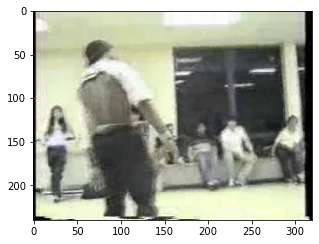

In [7]:
# Output frames to folder
( ffmpeg
    .input('./Original_Videos/'+video_file, ss=start, to=str(float(start)+float(duration)))
    .output('./frames/orig-%04d.bmp', format='image2')
    .run(capture_stdout=True)
)

out, _ = (
    ffmpeg
    .input('./Original_Videos/'+video_file, ss=start, to=str(float(start)+float(duration)))
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)
video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

n_frames = video.shape[0]
print('# Frames=', n_frames)

plt.figure(figsize=(5,5))
plt.imshow(video[test_frame,:,:,:])
plt.show()

### Generate spectrum for each frame

Kick frequencies up to about 150 Hz  
Hat at about 15 kHz

<ipython-input-8-cdf0fe4740ea>:10: RuntimeWarning: divide by zero encountered in log10
  sg = 10*np.log10(sg/np.amax(sg, axis=1, keepdims=True))


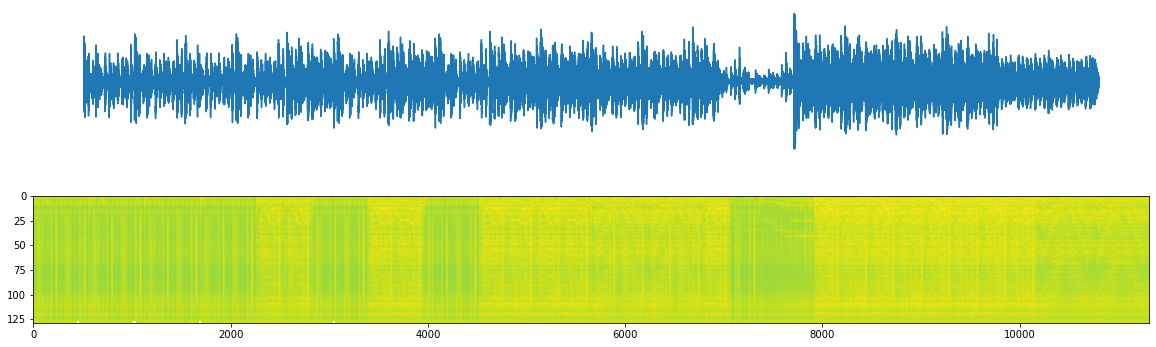

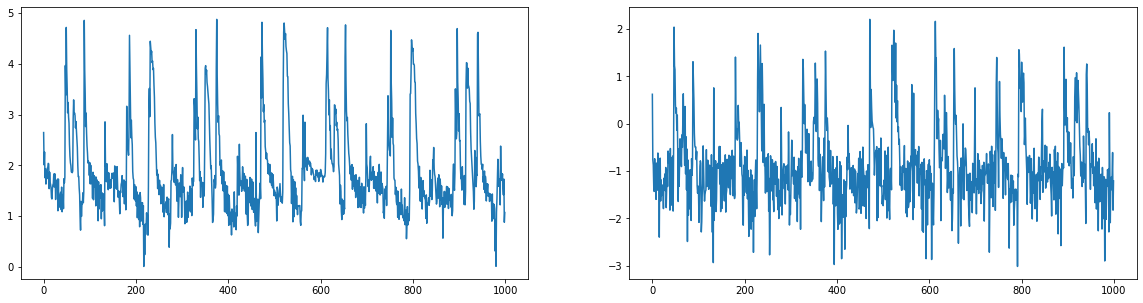

In [8]:
fs, data = wavfile.read("audio.wav")

# f, t, sg = signal.spectrogram(np.mean(data, axis=1), fs=fs, return_onesided=True)
f, t, sg = signal.spectrogram(np.mean(data, axis=1), fs=fs, return_onesided=True)
delta_t = float(duration)/t.size
sg_indx = np.round(np.linspace(0, sg.shape[1], n_frames)).astype(np.int16)
#sg = sg/np.amax(sg, axis=1, keepdims=True)
# sg = sg - np.mean(sg, axis=1, keepdims=True)
# sg = sg/np.std(sg, axis=1, keepdims=True)
sg = 10*np.log10(sg/np.amax(sg, axis=1, keepdims=True))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,6))
ax1.plot(data[:,0])
ax1.axis(False)
ax2.imshow(sg)
#ax2.axis(False)
ax2.set_aspect(10)

pow_tot = np.sum(sg, axis=0)
pow_tot[pow_tot == -np.inf] = pow_tot[0]
pow_tot = pow_tot - np.min(pow_tot)
pow_tot = pow_tot/np.std(pow_tot)

freq1 = sg[25,:]
freq1[freq1 == -np.inf] = freq1[0]
freq1 = freq1 - np.mean(freq1)
freq1 = freq1/np.std(freq1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(pow_tot[:1000])
ax2.plot(freq1[:1000])

# thresh = -60
# sg[sg<thresh] = thresh
# sg = sg - np.amin(sg, axis=1, keepdims=True)
# sg = sg/np.amax(sg, axis=1, keepdims=True)
# sg = sg - np.mean(sg, axis=1, keepdims=True)
# sg = sg/np.std(sg, axis=1, keepdims=True)
# sg = sg/np.amax(np.abs(sg), axis=1, keepdims=True)
# sg = sg - np.amin(sg, axis=1, keepdims=True)

# fig = plt.figure()
# plt.plot(f, sg[:,5])
# plt.plot(f, sg[:,10])
# plt.plot(f, sg[:,15])
# plt.show()


In [9]:
# %matplotlib notebook

# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(111)
# plt.ion()

# fig.show()
# fig.canvas.draw()

# for i in range(sg.shape[1]):
#     ax.clear()
#     ax.semilogx(f, sg[:,i])
#     ax.set_ylim(-60,0)
#     ax.set_xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000])
#     fig.canvas.draw()
#     plt.pause(delta_t)

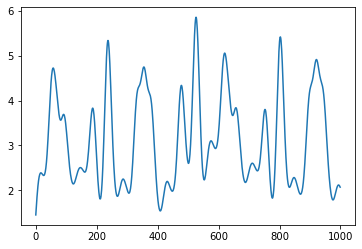

In [10]:
x_gauss = np.arange(-100, 100)
sigma = 10
gauss = (1/(sigma*np.sqrt(2*np.pi))) * np.exp((-x_gauss**2)/(2*sigma**2))
gauss = gauss/np.amax(gauss)

intensity = 10
exponent = 1.5
level = np.maximum(pow_tot, 0)**exponent
level = np.convolve(level, gauss, mode='same')
level = intensity * level/np.amax(level)

plt.plot(level[:1000])
plt.show()

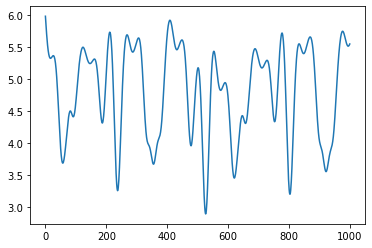

In [11]:
blur_intensity = 7
exponent = 1.5
blur_level = np.maximum(pow_tot, 0)**exponent
blur_level = np.convolve(blur_level, gauss, mode='same')
blur_level = level/np.amax(level)
blur_level = np.abs(blur_intensity * (1 - blur_level))
plt.plot(blur_level[:1000])
plt.show()

### Bend test frame

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


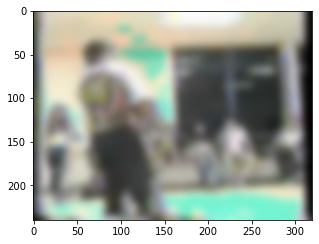

In [12]:
%matplotlib inline

# Test frame
#f_mod_indx = np.argsort(np.var(sg, axis=1))[-2:]
f_mod_indx = np.array([1, 90])   # Audio frequencies used to modulate video
f_indx = np.array([20, 90])      # Video 'frequencies' to modulate
level0 = level[sg_indx[test_frame]]

filelist = [ x for x in os.listdir('./frames') if x.endswith(".bmp") ]

in_path = './frames/'+filelist[test_frame]

b = sockbend.Bender(in_path)
b.bend([
        ("equalizer", {"frequency": f[f_indx[0]], "width_q": 1, "gain_db": level0}), 
        ("equalizer", {"frequency": f[f_indx[1]], "width_q": 1, "gain_db": level0}),
#         ("overdrive", {"gain_db": level0}),
#         ("reverb", {"reverberance": level0, "wet_gain": -8, "wet_only": False}),
#         ("echo", {"delays": [np.abs(np.amax(level0) - level0)+2]})
        ], 
        out_path='test_img.bmp')
# b.bend([
#         ("equalizer", {"frequency": f[f_indx[0]], "width_q": 1, "gain_db": (intensity/np.std(sg[f_indx[0],:]))*sg[f_indx[0], sg_indx[test_frame]]}), 
#         ("equalizer", {"frequency": f[f_indx[1]], "width_q": 1, "gain_db": (intensity/np.std(sg[f_indx[1],:]))*sg[f_indx[1], sg_indx[test_frame]]}),
#         ("overdrive", {"gain_db": (5/np.std(sg[f_indx[0],:]))*sg[f_indx[0], sg_indx[test_frame]]})
#         ("reverb", {"reverberance": 10, "wet_gain": -8, "wet_only": False})
#         ], 
#         out_path='test_img.bmp')
# b.bend([
#         ("echo", {"delays": [1]})], 
#         out_path='test_img.bmp')
# b.bend([
#         ("overdrive", {"gain_db": (intensity/np.std(sg[f_indx[0],:]))*sg[f_indx[0], sg_indx[test_frame]]})],
#         out_path='test_img.bmp')


# Blur with Pillow
OriImage = Image.open('test_img.bmp')
blurImage = OriImage.filter(ImageFilter.GaussianBlur(blur_level[sg_indx[test_frame]]))
blurImage.save('test_img.bmp')

im = plt.imread('./test_img.bmp')
fig = plt.figure(figsize=(5,5))
plt.imshow(im)
plt.show()

### Bend frames

In [13]:
filelist = [ f for f in os.listdir('./frames') if f.endswith(".bmp") ]
for i in range(len(filelist)-1):
    
    level1 = level[sg_indx[i]]
    blur_level1 = blur_level[sg_indx[i]]
    
    in_path = './frames/'+filelist[i]
    out_path = './bent_frames/bent-'+f'{i:04d}'+'.bmp'

    b = sockbend.Bender(in_path)
    b.bend([
        ("equalizer", {"frequency": f[f_indx[0]], "width_q": 1, "gain_db": level1}), 
        ("equalizer", {"frequency": f[f_indx[1]], "width_q": 1, "gain_db": level1}),
        ("overdrive", {"gain_db": level1}),
        ("reverb", {"reverberance": level1, "wet_gain": -8, "wet_only": False}),
#         ("echo", {"delays": [np.abs(np.amax(level1) - level1)+2]})
#         ("reverb", {})
        ], 
        out_path=out_path)
#     b.bend([
#         ("equalizer", {"frequency": f[f_indx[0]], "width_q": 1, "gain_db": (intensity/np.std(sg[f_indx[0],:]))*sg[f_indx[0], sg_indx[i]]}), 
#         ("equalizer", {"frequency": f[f_indx[1]], "width_q": 1, "gain_db": (intensity/np.std(sg[f_indx[1],:]))*sg[f_indx[1], sg_indx[i]]}),
#         ("overdrive", {"gain_db": np.abs((5/np.std(sg[f_indx[0],:]))*sg[f_indx[0], sg_indx[i]])+1})
# #         ("reverb", {})
#         ], 
#         out_path='./bent_frames/bent-'+f'{i:04d}'+'.bmp')
#     b.bend([
#         ("equalizer", {"frequency": f[np.random.randint(1, sg.shape[0])], "width_q": 1, "gain_db": (5/np.std(sg[f_indx[0],:]))*sg[f_indx[0], sg_indx[i]]}), 
#         ("equalizer", {"frequency": f[np.random.randint(1, sg.shape[0])], "width_q": 1, "gain_db": (5/np.std(sg[f_indx[1],:]))*sg[f_indx[1], sg_indx[i]]})], 
#         out_path='./bent_frames/bent-'+f'{i:04d}'+'.bmp')
#     b.bend([
#         ("echo", {"delays": [np.abs((2/np.std(sg[f_indx[0],:]))*sg[f_indx[0], sg_indx[i]])+1]})], 
#         out_path='./bent_frames/bent-'+f'{i:04d}'+'.bmp')
#     b.bend([
#         ("overdrive", {"gain_db": np.abs((1/np.std(sg[f_indx[0],:]))*sg[f_indx[0], sg_indx[i]])+1})],
#         out_path='./bent_frames/bent-'+f'{i:04d}'+'.bmp')

    OriImage = Image.open(out_path)
    blurImage = OriImage.filter(ImageFilter.GaussianBlur(blur_level1))
    blurImage.save(out_path)

### Combine frames

In [14]:
subprocess.call("del bent_video.mp4", shell=True)

( ffmpeg
    .input('./bent_frames/bent-%04d.bmp', framerate=FR)
    .output('bent_video.mp4')
    .run()
)

(None, None)

### Merge video and audio

In [15]:
subprocess.call("del bent_final.mp4", shell=True)

in1 = ffmpeg.input('bent_video.mp4')
in2 = ffmpeg.input('audio.wav')
v1 = in1.video
a2 = in2.audio
ffmpeg.output(v1, a2, 'bent_final.mp4').run()

(None, None)